<a href="https://colab.research.google.com/github/dileep5253/Community_Detection/blob/main/Community-Detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialisation

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
#Import data set
df = pd.read_excel('/content/gdrive/MyDrive/OnlineRetail.xlsx', header = 0) # Changed path to /content/gdrive/MyDrive/OnlineRetail.xlsx

In [8]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')


dataset dimensions are: (541909, 8)


InvoiceNo StockCode                         Description  \
count    541909.0    541909                              540455   
unique    25900.0      4070                                4223   
top      573585.0    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq       1114.0      2313                                2369   
mean          NaN       NaN                                 NaN   
min           NaN       NaN                                 NaN   
25%           NaN       NaN                                 NaN   
50%           NaN       NaN                                 NaN   
75%           NaN       NaN                                 NaN   
max           NaN       NaN                                 NaN   
std           NaN       NaN                                 NaN   

             Quantity                    InvoiceDate      UnitPrice  \
count   541909.000000                         541909  541909.000000   
unique            NaN                            NaN            NaN   
top               NaN                            NaN            NaN   
freq              NaN                            NaN            NaN   
mean         9.552250  2011-07-04 13:34:57.156386048       4.611114   
min     -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%          1.000000            2011-03-28 11:34:00       1.250000   
50%          3.000000            2011-07-19 17:17:00       2.080000   
75%         10.000000            2011-10-19 11:27:00       4.130000   
max      80995.000000            2011-12-09 12:50:00   38970.000000   
std        218.081158                            NaN      96.759853   

           CustomerID         Country  
count   406829.000000          541909  
unique            NaN              38  
top               NaN  United Kingdom  
freq              NaN          495478  
mean     15287.690570             NaN  
min      12346.000000             NaN  
25%      13953.000000             NaN  
50%      15152.000000             NaN  
75%      16791.000000             NaN  
max      18287.000000             NaN  
std       1713.600303             NaN

In [9]:
#Taking a smaller set of the data to speed up computations
df_sample = df.iloc[:4000]
print(df_sample)

     InvoiceNo StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3       536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4       536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...        ...       ...                                  ...       ...   
3995    536742     22558      CLOTHES PEGS RETROSPOT PACK 24          2   
3996    536742     22379             RECYCLING BAG RETROSPOT          1   
3997    536742     22470                HEART OF WICKER LARGE         1   
3998    536742     21211       SET OF 72 SKULL PAPER  DOILIES         1   
3999    536742     22469                HEART OF WICKER SMALL         2   

             InvoiceDate  UnitPrice  CustomerID         Country  
0    2010-12-01 08:26:00       2.

## Data Pre-processing

In [10]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID)==False]

#Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#Data cleaning' to raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
print()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')


<ipython-input-10-a50eeca40dda>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
<ipython-input-10-a50eeca40dda>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, t

In [11]:
#Count number of products and number of customers in the reduced dataset
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 137
Number of products in dataset: 1131


## Create a Bipartite Graph

In [12]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1
print(ratings)

StockCode   10002  10125  10133  10135  16014  16016  16046  16235  16237  \
CustomerID                                                                  
12431           0      0      0      0      0      0      0      0      0   
12433           0      0      0      0      0      0      0      0      0   
12583          48      0      0      0      0      0      0      0      0   
12662           0      0      0      0      0      0      0      0      0   
12748           0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18041           0      0      0      0      0      0      1      0      0   
18074           0      0      0      0      0      0      0      0      0   
18085           0      0      0      0      0      0      0      0      0   
18144           0      0      0      0      0      0      0      0      0   
18229           0      0      0      0      0      0      0      0      0   

## Convert to a Weighted Product Graph

In [13]:
import numpy as np
import pandas as pd

# Example: number of products (no_products) and binary ratings DataFrame (ratings_binary)
# no_products = 5  # Example: 5 products
# ratings_binary = pd.DataFrame([[0, 1, 0, 1, 1],   # Example: Binary ratings where 1 means purchased, 0 means not purchased
#                                [1, 1, 0, 0, 1],
#                                [0, 0, 1, 1, 0],
#                                [1, 0, 1, 1, 0],
#                                [1, 1, 1, 0, 1]])

# Initialize a zero matrix for product interactions
products_integer = np.zeros((no_products, no_products))

# Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i in range(no_products):
    for j in range(no_products):
        if i != j:
            df_ij = ratings_binary.iloc[:, [i, j]]
            sum_ij = df_ij.sum(axis=1)
            pairings_ij = len(sum_ij[sum_ij == 2])
            products_integer[i, j] = pairings_ij
            products_integer[j, i] = pairings_ij

# Print the interaction matrix
print(products_integer)


Counting how many times each pair of products has been purchased...
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [15]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)
print(times_purchased)

Counting how many times each individual product has been purchased...
[30. 73. 27. ... 20. 63. 34.]


In [16]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
            products_weighted[j,i] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
print(products_weighted)


Building weighted product matrix...
[[0.       0.       0.       ... 0.       0.       0.015625]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.015625 0.       0.       ... 0.       0.       0.      ]]


## Visualise Weighted Product matrix

In [17]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

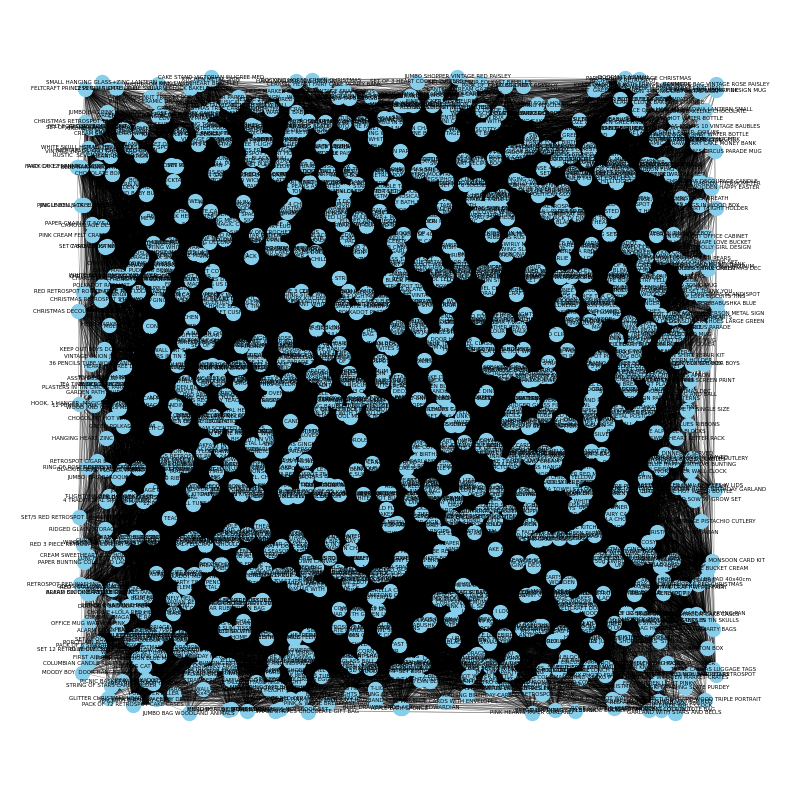

In [18]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assuming products_weighted is a 2D NumPy array (weighted adjacency matrix)
# and nodes_labels is a list of product names or descriptions.
# Example:
# products_weighted = np.array([[...], [...], ...]) # A weighted adjacency matrix
# nodes_labels = ['product1', 'product2', 'product3', ...]

G = nx.from_numpy_array(products_weighted)  # This creates a weighted graph from the matrix

pos = nx.random_layout(G)

labels = {idx: nodes_labels[idx] for idx in range(len(nodes_labels))}

plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=100)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.3, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show()


#### For better visualisation, export the graph to Gephi

In [19]:
#Export graph to Gephi
H=nx.relabel_nodes(G,labels) #create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

Communities detected by Louvain method:
Community 1: [13, 17, 24, 26, 29, 39, 48]
Community 2: [1, 28, 33, 43]
Community 3: [2, 9, 12, 18, 22, 46, 49]
Community 4: [11, 20, 25, 30]
Community 5: [3, 6, 16, 37]
Community 6: [0, 19, 21, 36, 41, 42]
Community 7: [14, 31, 34, 38]
Community 8: [5, 7, 10, 27, 44]
Community 9: [4, 35, 40, 45]
Community 10: [8, 15, 23, 32, 47]


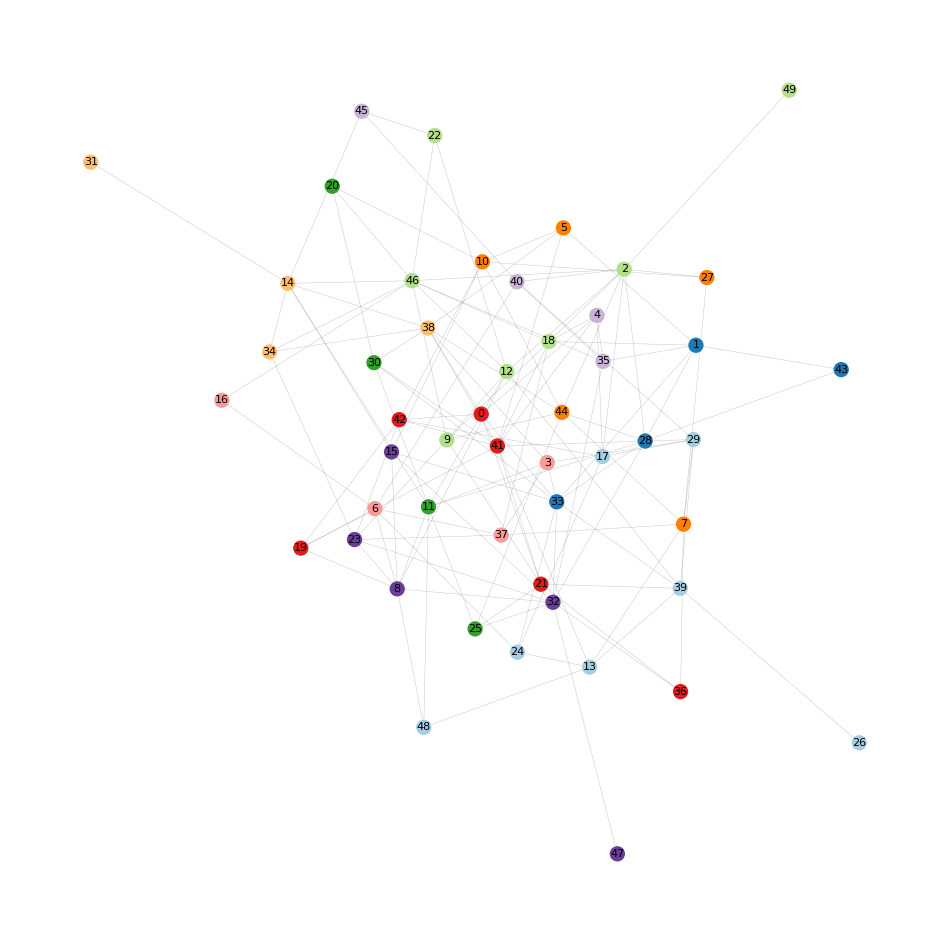

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

# Function to get paired color palette for node coloring based on communities
def get_paired_color_palette(size):
    palette = []
    for i in range(size * 2):  # Generate enough colors
        palette.append(plt.cm.Paired(i))
    return palette

G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes, 10% edge probability

# Apply the Louvain method for community detection
louvain = community_louvain.best_partition(G, resolution=1.5)
values = list(louvain.values())  # List of community assignments for each node

# Initialize an empty list to store communities
communities = []

# Loop over each unique community ID to group the nodes in each community
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if louvain[n] == i]
    communities.append(nodelist)

# Print the communities
print("Communities detected by Louvain method:")
for idx, community in enumerate(communities):
    print(f"Community {idx + 1}: {community}")

palette = get_paired_color_palette(len(communities))

# Visualize the graph
plt.figure(figsize=(12, 12))
node_colors = [palette[values[node]] for node in G.nodes]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.3, alpha=0.5)
labels = {node: str(node) for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.axis('off')

# Show the plot
plt.show()


## Visualise detected communities

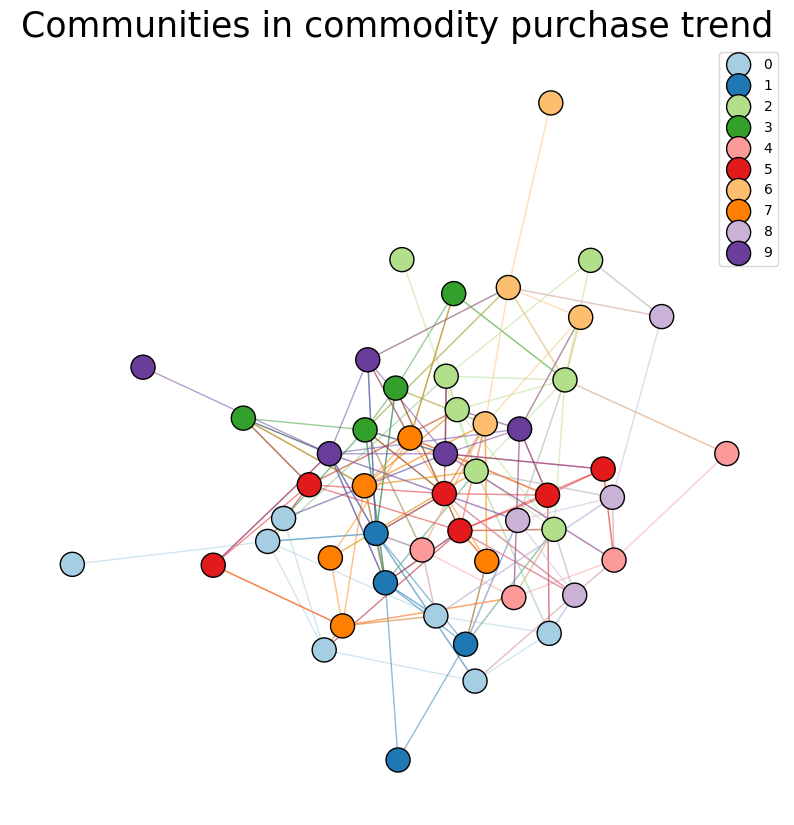

In [21]:
#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Communities in commodity purchase trend', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

## Performance Metrics

Modularity: 0.29738820736050653


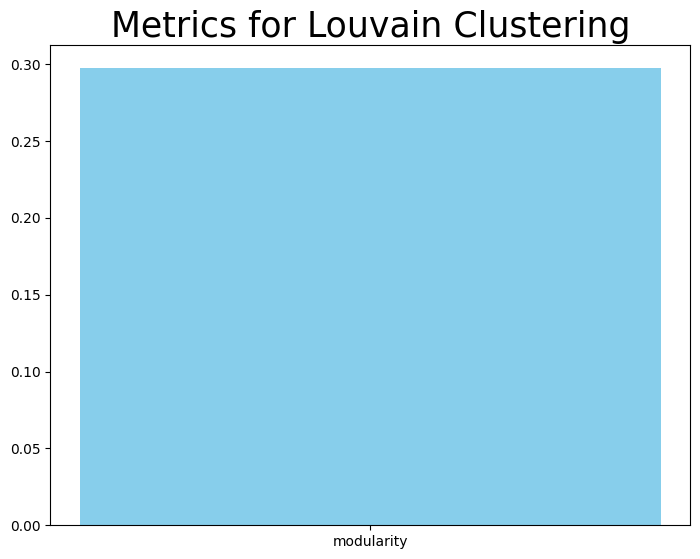

In [22]:
# Transform all the graphs in the same format
clusters = []
for cluster in range(len(set(louvain.values()))):
    cluster_set = set()
    for k, v in louvain.items():
        if v == cluster:
            cluster_set.add(k)
    clusters.append(cluster_set)  # Append the set of nodes to the clusters list

# Calculate modularity
modularity = nx.community.modularity(G, clusters)
print("Modularity:", modularity)

# Plot only modularity since 'coverage' and 'performance' are not available
x = ['modularity']
y = [modularity]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(x, y, color=['skyblue'])
plt.title('Metrics for Louvain Clustering', fontdict={'fontsize': 25})
plt.show()



## Detected Community Analysis

In [23]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 10


In [24]:
# Apply the Louvain method to the products_weighted graph (assuming it's your main graph)
louvain = community_louvain.best_partition(nx.from_numpy_array(products_weighted), resolution=1.5)
values = list(louvain.values())

# Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns=['product_description'])
products_communities['community_id'] = values  # Now 'values' should have the correct length
print(products_communities)

               product_description  community_id
0      INFLATABLE POLITICAL GLOBE             24
1          MINI FUNKY DESIGN TAPES             1
2     COLOURING PENCILS BROWN TUBE             2
3     COLOURING PENCILS BROWN TUBE             3
4      SMALL CHINESE STYLE SCISSOR             2
...                            ...           ...
1126     LETTER "S" BLING KEY RING            18
1127     LETTER "V" BLING KEY RING            18
1128                      CARRIAGE            22
1129                        Manual            23
1130                       POSTAGE            15

[1131 rows x 2 columns]


In [25]:
#Community 1
products_communities[products_communities['community_id']==1].head(40)

product_description  community_id
1                 MINI FUNKY DESIGN TAPES             1
47                BLUE ROSE FABRIC MIRROR             1
102     SET/10 RED POLKADOT PARTY CANDLES             1
160                   SKULLS WRITING SET              1
162               DINOSAURS  WRITING SET              1
193                   TOADSTOOL MONEY BOX             1
308                 HEART T-LIGHT HOLDER              1
309                 STAR  T-LIGHT HOLDER              1
310         CHRISTMAS TREE T-LIGHT HOLDER             1
372        VINTAGE PAISLEY STATIONERY SET             1
394           RIBBON REEL STRIPES DESIGN              1
422            PARTY CONES CANDY ASSORTED             1
490            HEART FILIGREE DOVE  SMALL             1
491             HEART FILIGREE DOVE LARGE             1
497            OFFICE MUG WARMER POLKADOT             1
509     RETROSPOT PARTY BAG + STICKER SET             1
535               JUMBO BAG PINK POLKADOT             1
562         PENCIL CASE LIFE IS BEAUTIFUL             1
567          MEASURING TAPE BABUSHKA BLUE             1
568           MEASURING TAPE BABUSHKA RED             1
597      SET OF 2 TINS JARDIN DE PROVENCE             1
644   WOODEN HEART CHRISTMAS SCANDINAVIAN             1
652             PACK OF 6 BIRDY GIFT TAGS             1
667           WOODEN ROUNDERS GARDEN SET              1
674             SET OF 6 SOLDIER SKITTLES             1
708           JUMBO BAG DOLLY GIRL DESIGN             1
743         RIBBON REEL SOCKS AND MITTENS             1
745        RIBBON REEL CHRISTMAS PRESENT              1
749       MAKE YOUR OWN PLAYTIME CARD KIT             1
751        MAKE YOUR OWN MONSOON CARD KIT             1
799          PACK 3 BOXES BIRD PANNETONE              1
814       3 TIER CAKE TIN GREEN AND CREAM             1
843     PAPER CHAIN KIT VINTAGE CHRISTMAS             1
871       60 CAKE CASES VINTAGE CHRISTMAS             1
890                     SOLDIERS EGG CUP              1
957         ASSORTED COLOUR BIRD ORNAMENT             1
973             THREE CANVAS LUGGAGE TAGS             1
989        SWIRLY CIRCULAR RUBBERS IN BAG             1
1017                 DOORMAT BLACK FLOCK              1
1092              JUMBO BAG RED RETROSPOT             1

## Target Advertising


In [26]:
import pandas as pd

products_weighted_pd = pd.DataFrame(products_weighted, columns=nodes_labels)

products_weighted_pd.set_index(products_weighted_pd.columns, inplace=True)  # Removed extra positional argument 'product'

products_weighted_pd.index.name = 'product'

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis=1), axis=0)

print(products_prob)


                              INFLATABLE POLITICAL GLOBE   \
product                                                     
INFLATABLE POLITICAL GLOBE                           0.00   
MINI FUNKY DESIGN TAPES                              0.00   
COLOURING PENCILS BROWN TUBE                         0.00   
COLOURING PENCILS BROWN TUBE                         0.00   
SMALL CHINESE STYLE SCISSOR                          0.00   
...                                                   ...   
LETTER "S" BLING KEY RING                            0.00   
LETTER "V" BLING KEY RING                            0.00   
CARRIAGE                                             0.00   
Manual                                               0.00   
POSTAGE                                              0.75   

                              MINI FUNKY DESIGN TAPES  \
product                                                 
INFLATABLE POLITICAL GLOBE                        0.0   
MINI FUNKY DESIGN TAPES            

In [27]:
#Saving the trained model for use in the UI
products_prob.to_csv('products_prob.csv')

---
## Testing



In [28]:
#Add item to basket
basket = ['HOME BUILDING BLOCK WORD']
#Select the number of relevant items to suggest
no_of_suggestions = 3

all_of_basket = products_prob[basket]
all_of_basket = all_of_basket.sort_values(by = basket, ascending=False)
suggestions_to_customer = list(all_of_basket.index[:no_of_suggestions])

print('You may also consider buying:', suggestions_to_customer)

You may also consider buying: ['LOVE BUILDING BLOCK WORD', 'BATH BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT']


In [29]:
pip install networkx matplotlib


In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph (e.g., Erdos-Renyi graph)
G = nx.erdos_renyi_graph(50, 0.1)  # 50 nodes, 10% probability of an edge between nodes


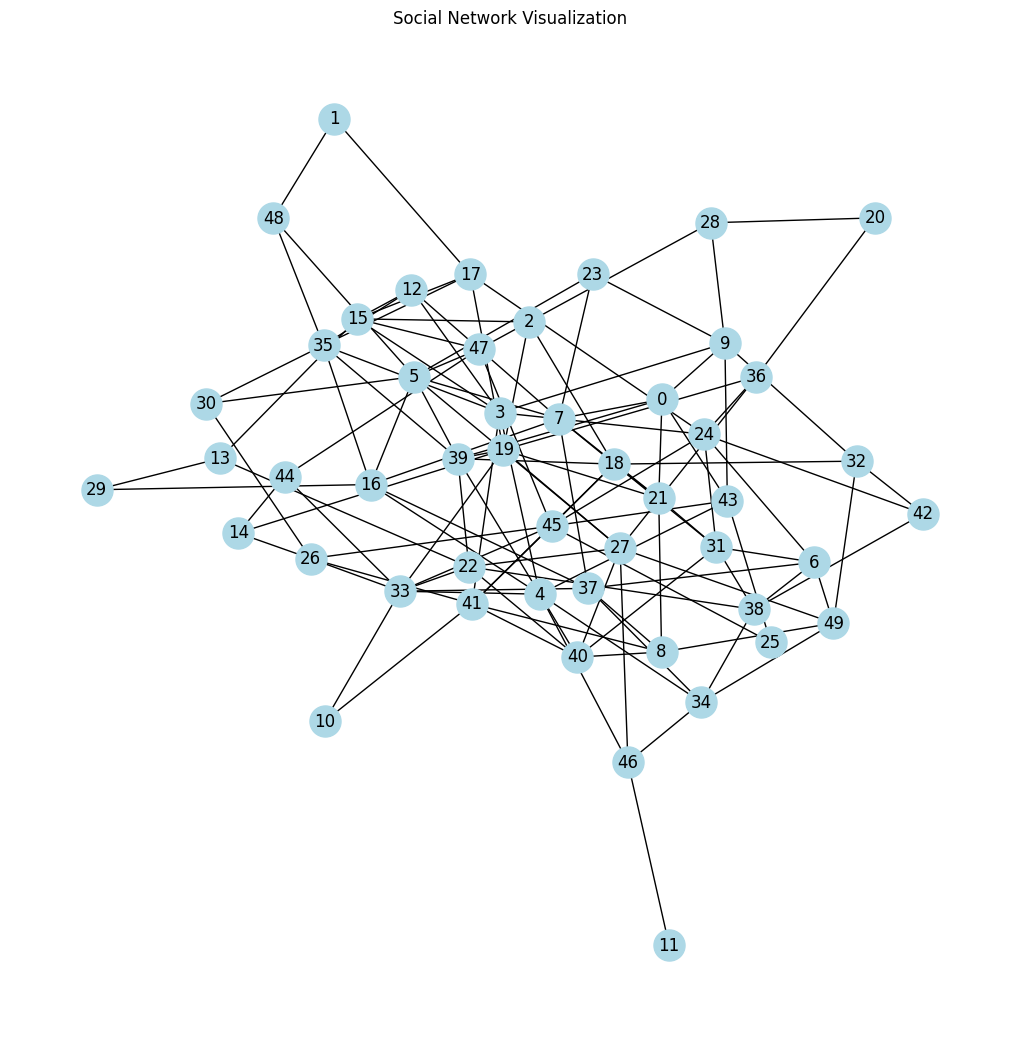

In [31]:
# Draw the network
plt.figure(figsize=(10, 10))  # Set the size of the plot
nx.draw(G, with_labels=True, node_size=500, node_color='lightblue', font_size=12)
plt.title("Social Network Visualization")
plt.show()


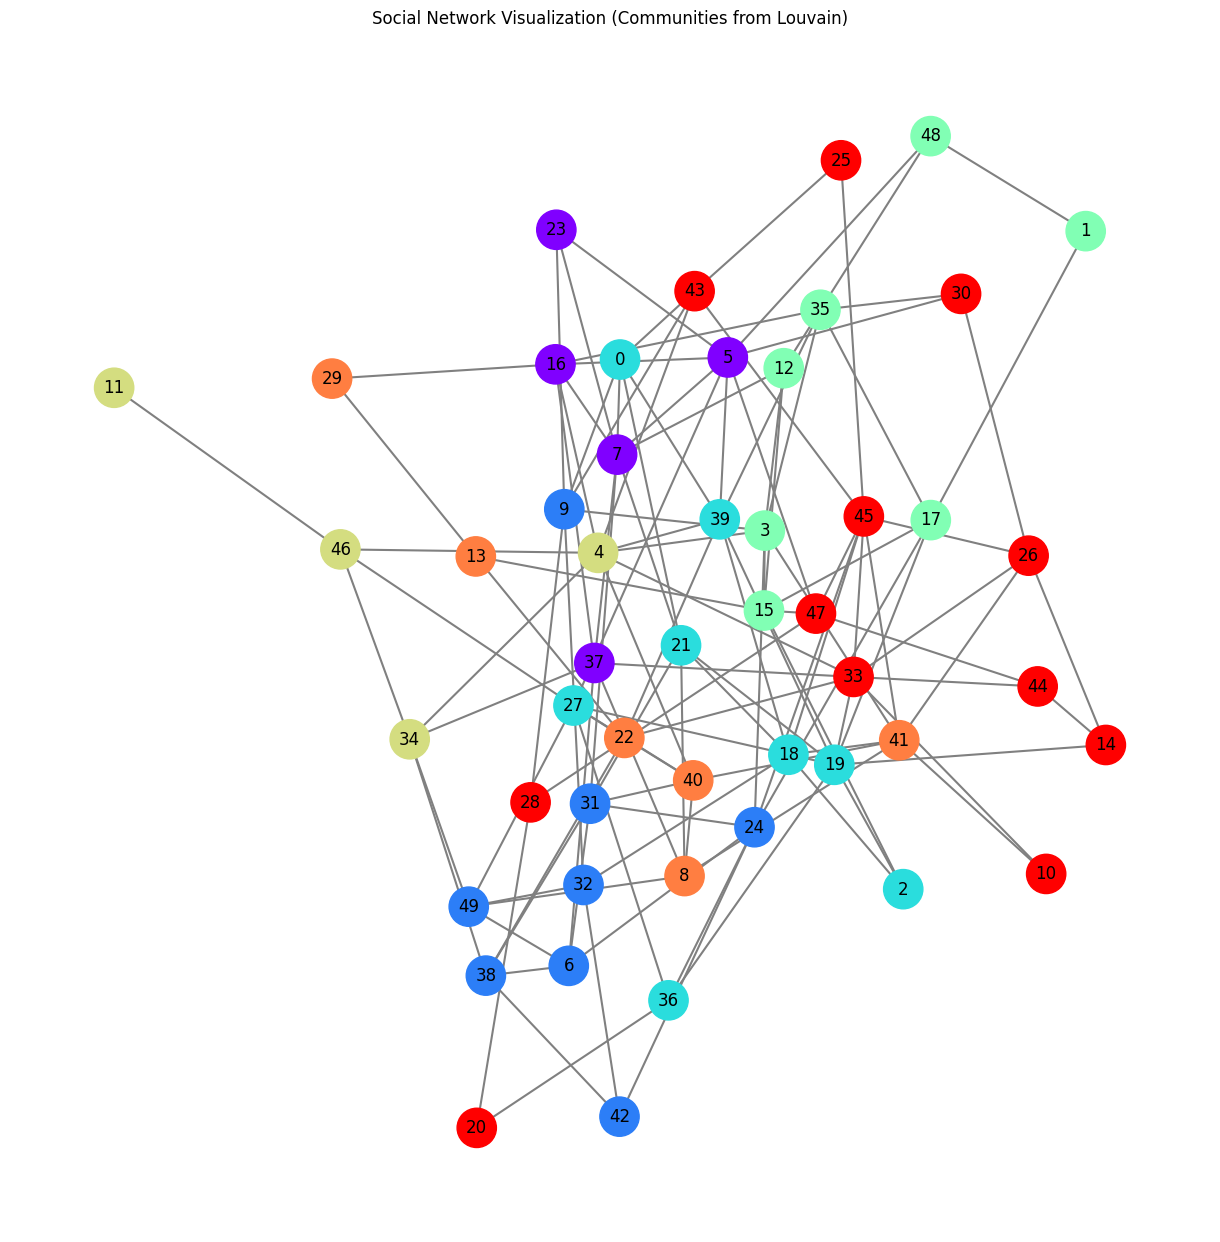

In [32]:
# Assuming you have already detected communities, like using the Louvain method
from community import community_louvain

# Detect communities (partition)
partition = community_louvain.best_partition(G)

# Color nodes based on community
community_color = [partition[node] for node in G.nodes]
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color=community_color, cmap=plt.cm.rainbow, font_size=12, font_color='black', edge_color='gray', width=1.5)
plt.title("Social Network Visualization (Communities from Louvain)")
plt.show()


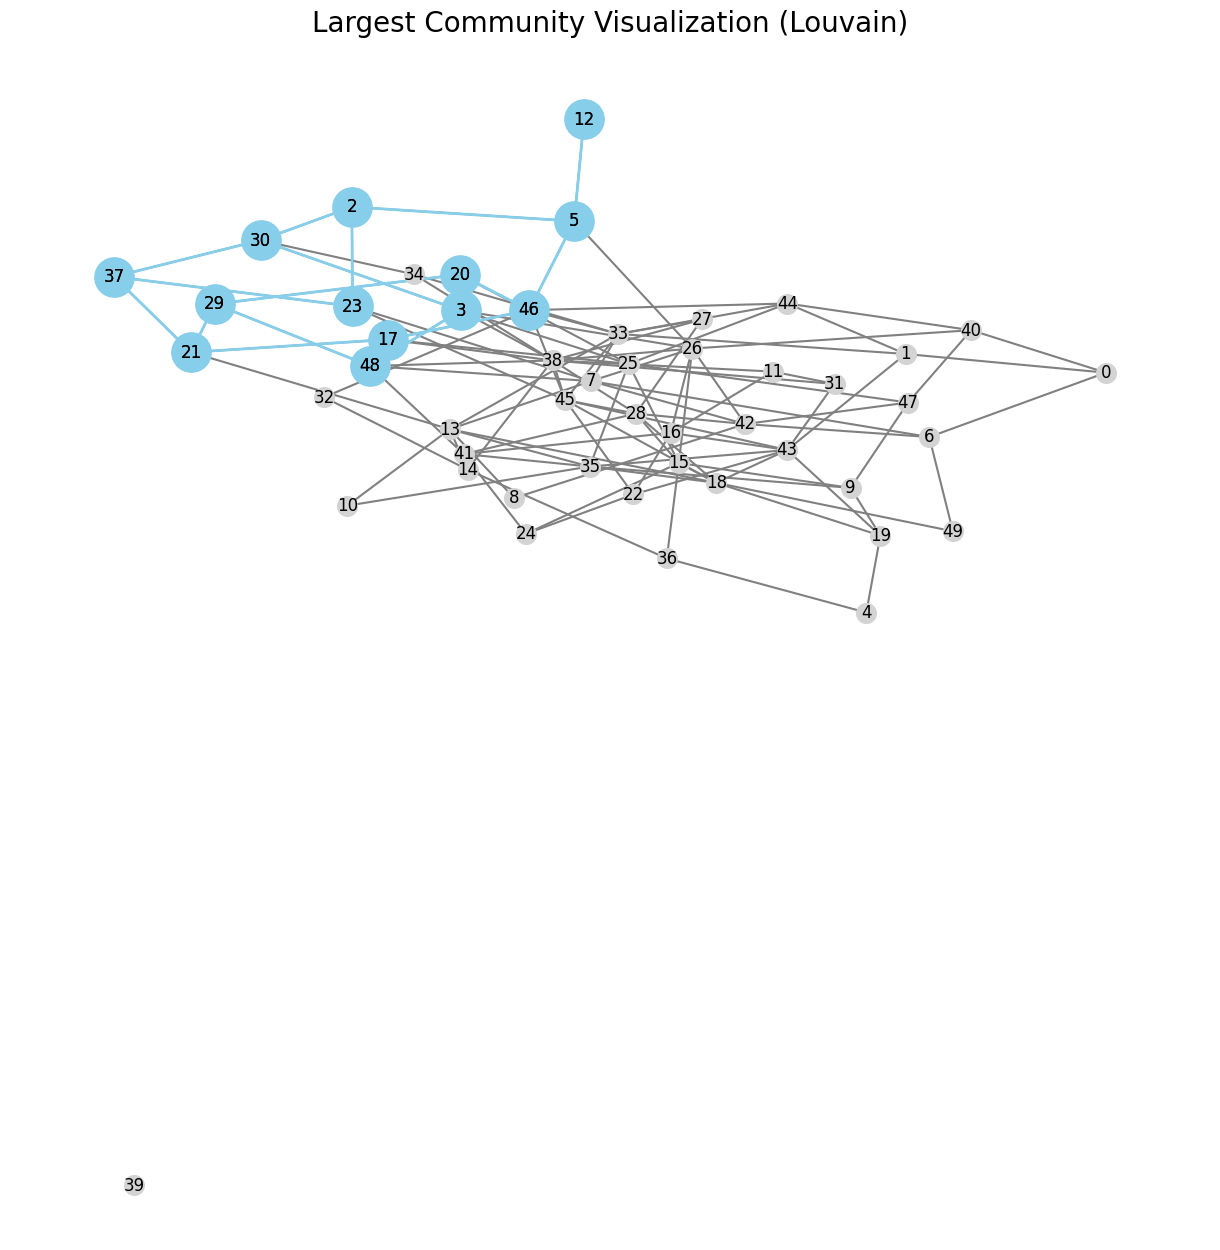

In [33]:

# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
# Import the community_louvain module directly
from community import community_louvain  # Louvain method for community detection

# Create a random graph (or replace it with your own graph)
G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes with 10% probability for an edge

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Find the largest community
# Count the size of each community
community_sizes = {}
for node, community_id in partition.items():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Find the community with the maximum size
largest_community_id = max(community_sizes, key=community_sizes.get)

# Get the nodes belonging to the largest community
largest_community_nodes = [node for node, community_id in partition.items() if community_id == largest_community_id]

# Create a subgraph for the largest community
largest_community_subgraph = G.subgraph(largest_community_nodes)

# Choose a layout for visualization (Spring layout)
pos = nx.spring_layout(G, seed=42)  # Positions for nodes using spring layout

# Create the plot
plt.figure(figsize=(12, 12))

# Draw the entire graph with light gray nodes for background
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgray', font_size=12, font_color='black', edge_color='gray', width=1.5)

# Then, draw the largest community with a distinct color (e.g., 'skyblue')
nx.draw(largest_community_subgraph, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=12, font_color='black', edge_color='skyblue', width=2)

# Title for the plot
plt.title("Largest Community Visualization (Louvain)", fontsize=20)

# Show the plot
plt.show()


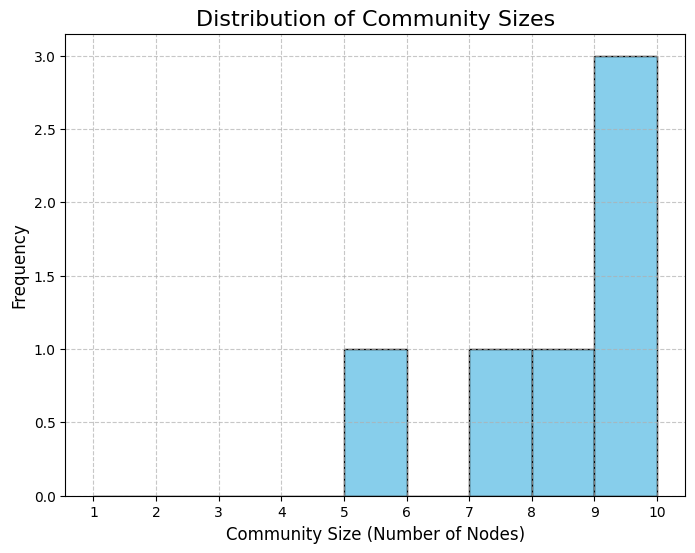

In [34]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain  # Louvain method for community detection

# Create a random graph (or replace it with your own graph)
G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes with 10% probability for an edge

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Calculate the size of each community
community_sizes = {}
for node, community_id in partition.items():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Plot the distribution of community sizes
plt.figure(figsize=(8, 6))

# Plot a histogram of community sizes
plt.hist(community_sizes.values(), bins=range(1, max(community_sizes.values()) + 1), color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Community Sizes', fontsize=16)
plt.xlabel('Community Size (Number of Nodes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(1, max(community_sizes.values()) + 1))
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [41]:
# Sample data for faster computation
df_sample = df.iloc[:4000]

# Create Graph from Transaction Data
G = nx.Graph()
for index, row in df_sample.iterrows():
    # Ensure Quantity is positive or 0, replace negative with 0
    quantity = max(0, row['Quantity'])
    G.add_edge(row['CustomerID'], row['StockCode'], weight=quantity)

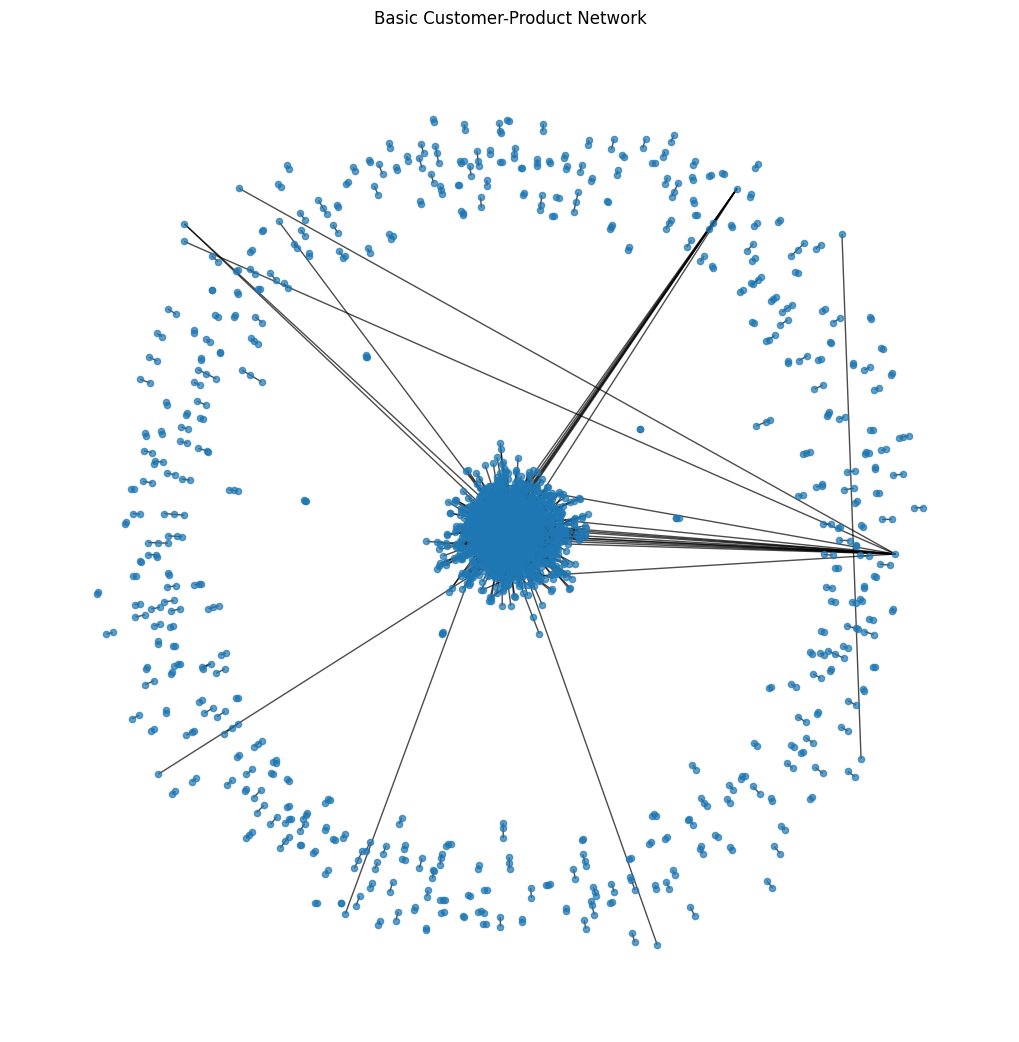

In [42]:
# Apply Community Detection
partition = community_louvain.best_partition(G)

# Visualization 1: Basic Network Graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=20, with_labels=False, alpha=0.7)
plt.title("Basic Customer-Product Network")
plt.show()

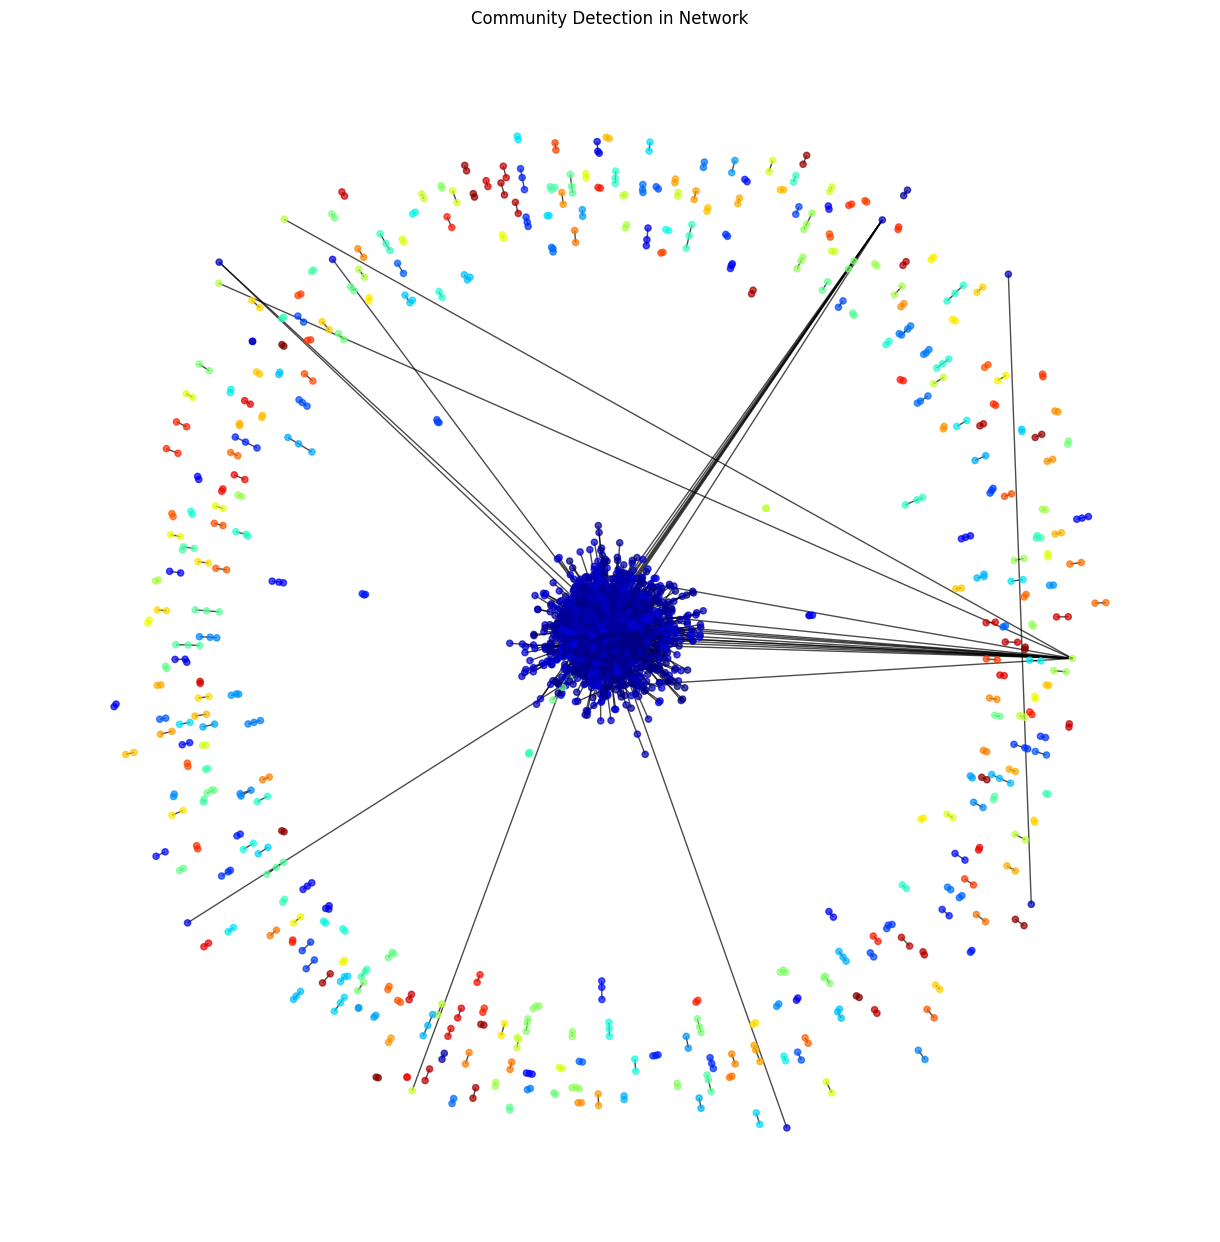

In [43]:
# Visualization 2: Community Detection Graph
plt.figure(figsize=(12, 12))
colors = [partition[node] if node in partition else 0 for node in G.nodes()]
nx.draw(G, pos, node_color=colors, node_size=20, with_labels=False, cmap=plt.cm.jet, alpha=0.7)
plt.title("Community Detection in Network")
plt.show()

In [45]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.5 MB/s eta 0:00:00


In [46]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
from pyvis.network import Network
import plotly.express as px
from IPython.display import display, HTML

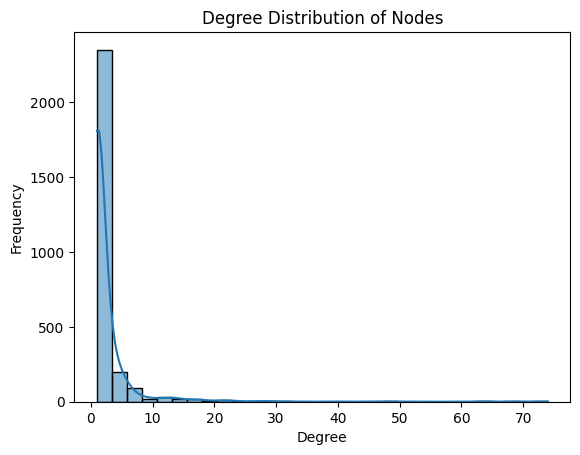

In [49]:
# Visualization 4: Degree Distribution
degrees = [val for (node, val) in G.degree()]
sns.histplot(degrees, bins=30, kde=True)
plt.title("Degree Distribution of Nodes")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [50]:
# Visualization 5: Centrality Analysis
centrality = nx.degree_centrality(G)
central_df = pd.DataFrame.from_dict(centrality, orient='index', columns=['Centrality'])
fig = px.histogram(central_df, x='Centrality', nbins=30, title="Centrality Distribution")
fig.show()


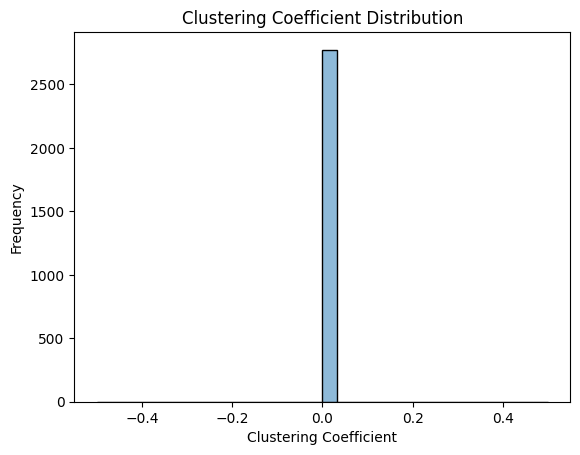

In [51]:
# Visualization 6: Clustering Coefficient Distribution
clustering_coeffs = nx.clustering(G)
clustering_df = pd.DataFrame.from_dict(clustering_coeffs, orient='index', columns=['Clustering Coefficient'])
sns.histplot(clustering_df['Clustering Coefficient'], bins=30, kde=True)
plt.title("Clustering Coefficient Distribution")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.show()

<ipython-input-52-6f5cba3b20d1>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




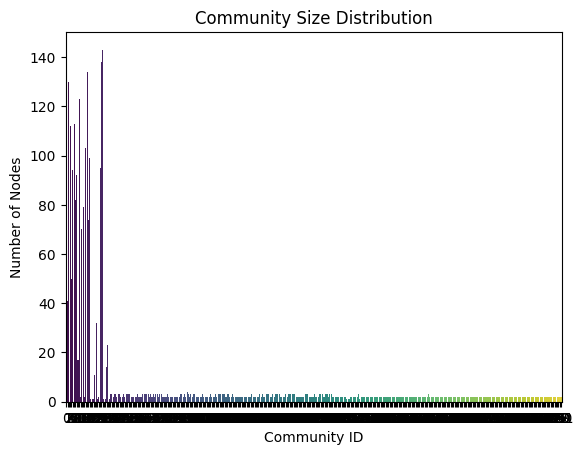

In [52]:
# Visualization 7: Community Size Distribution
community_sizes = pd.Series(list(partition.values())).value_counts()
sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")
plt.title("Community Size Distribution")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()

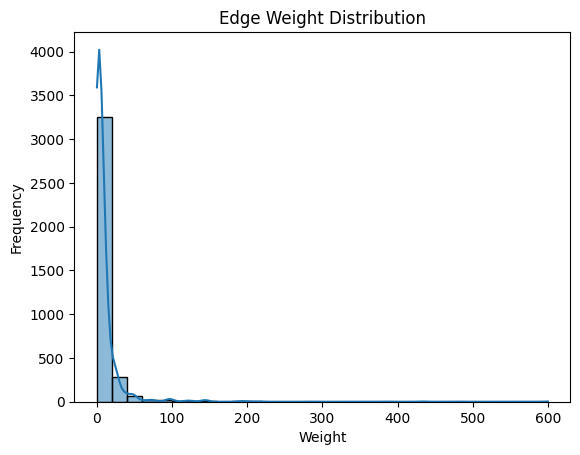

In [53]:
# Visualization 8: Edge Weight Distribution
edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
sns.histplot(edge_weights, bins=30, kde=True)
plt.title("Edge Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

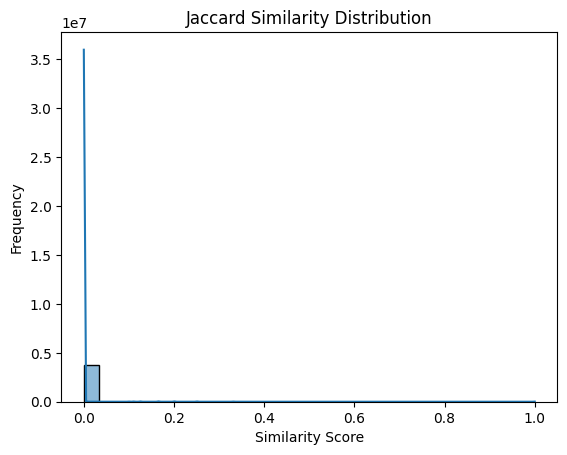

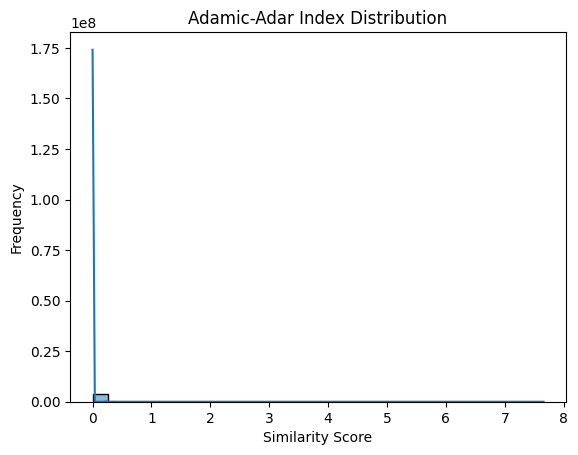

In [54]:
# Compute Jaccard Similarity for Each Edge
jaccard_sim = list(nx.jaccard_coefficient(G))
jaccard_df = pd.DataFrame(jaccard_sim, columns=['Node1', 'Node2', 'Jaccard Similarity'])

# Visualization 9: Jaccard Similarity Distribution
sns.histplot(jaccard_df['Jaccard Similarity'], bins=30, kde=True)
plt.title("Jaccard Similarity Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

# Compute Adamic-Adar Index for Each Edge
adamic_adar = list(nx.adamic_adar_index(G))
adamic_adar_df = pd.DataFrame(adamic_adar, columns=['Node1', 'Node2', 'Adamic-Adar Index'])

# Visualization 10: Adamic-Adar Index Distribution
sns.histplot(adamic_adar_df['Adamic-Adar Index'], bins=30, kde=True)
plt.title("Adamic-Adar Index Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

# Save updated graph for Gephi analysis
nx.write_gexf(G, "enhanced_community_network.gexf")

<ipython-input-55-c151031b4011>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




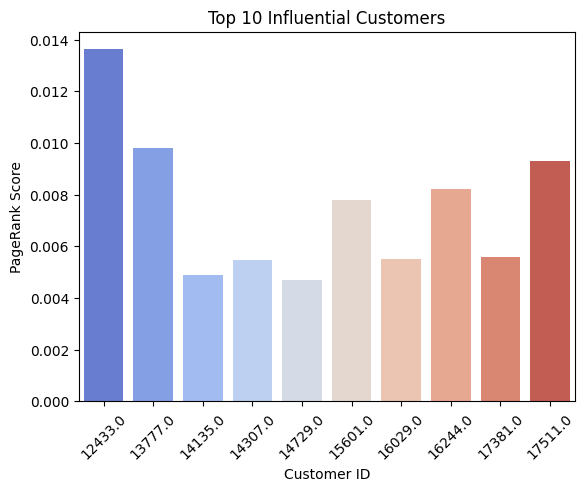

In [55]:
# Compute PageRank for Influential Customers
pagerank = nx.pagerank(G)
pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# Visualization 6: Top Influential Customers
sns.barplot(x=pagerank_df.index[:10], y=pagerank_df['PageRank'][:10], palette="coolwarm")
plt.title("Top 10 Influential Customers")
plt.xlabel("Customer ID")
plt.ylabel("PageRank Score")
plt.xticks(rotation=45)
plt.show()


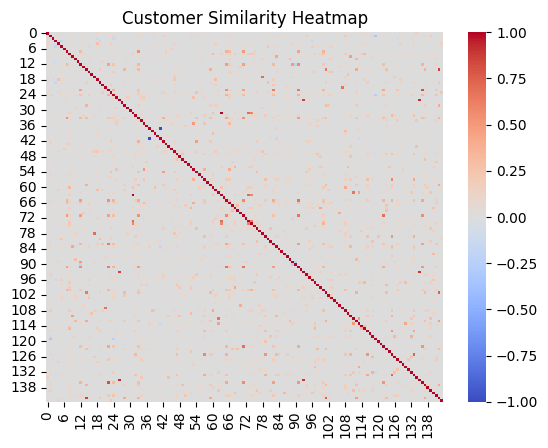

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
from pyvis.network import Network
import plotly.express as px
from IPython.display import display, HTML
from scipy.spatial.distance import pdist, squareform # Import the squareform function

# Compute Customer Similarity Matrix
customer_product_matrix = df_sample.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
similarity_matrix = 1 - squareform(pdist(customer_product_matrix, metric='cosine'))
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title("Customer Similarity Heatmap")
plt.show()

In [58]:
# Perform K-Means Clustering for Market Segmentation
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(customer_product_matrix)
df_sample['Cluster'] = kmeans.labels_

NameError: name 'KMeans' is not defined

In [59]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
from pyvis.network import Network
import plotly.express as px
from IPython.display import display, HTML
from scipy.spatial.distance import pdist, squareform # Import the squareform function
from sklearn.cluster import KMeans # Import KMeans from sklearn.cluster

# Perform K-Means Clustering for Market Segmentation
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(customer_product_matrix)
df_sample['Cluster'] = kmeans.labels_

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [60]:
# Perform K-Means Clustering for Market Segmentation
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# Convert column names to strings
customer_product_matrix.columns = customer_product_matrix.columns.astype(str)
kmeans.fit(customer_product_matrix)
df_sample['Cluster'] = kmeans.labels_

ValueError: Length of values (144) does not match length of index (4000)

In [61]:
# Perform K-Means Clustering for Market Segmentation
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# Convert column names to strings
customer_product_matrix.columns = customer_product_matrix.columns.astype(str)
kmeans.fit(customer_product_matrix)

# Get cluster labels for each customer
cluster_labels = pd.Series(kmeans.labels_, index=customer_product_matrix.index)

# Merge cluster labels into df_sample based on CustomerID
df_sample = df_sample.merge(cluster_labels.rename('Cluster'), left_on='CustomerID', right_index=True, how='left')

<ipython-input-62-2f754d1584dd>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




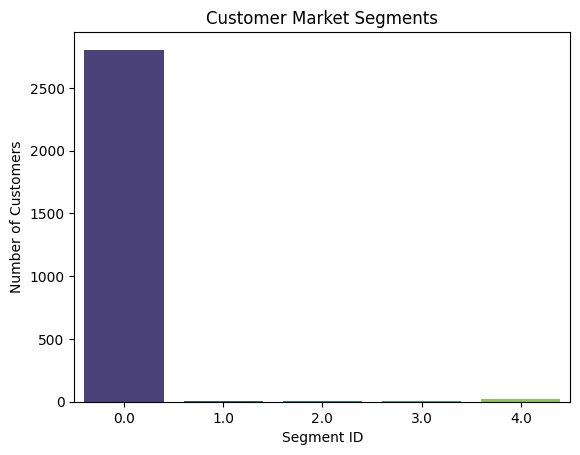

In [62]:
# Visualization 7: Customer Segments
sns.countplot(x=df_sample['Cluster'], palette='viridis')
plt.title("Customer Market Segments")
plt.xlabel("Segment ID")
plt.ylabel("Number of Customers")
plt.show()


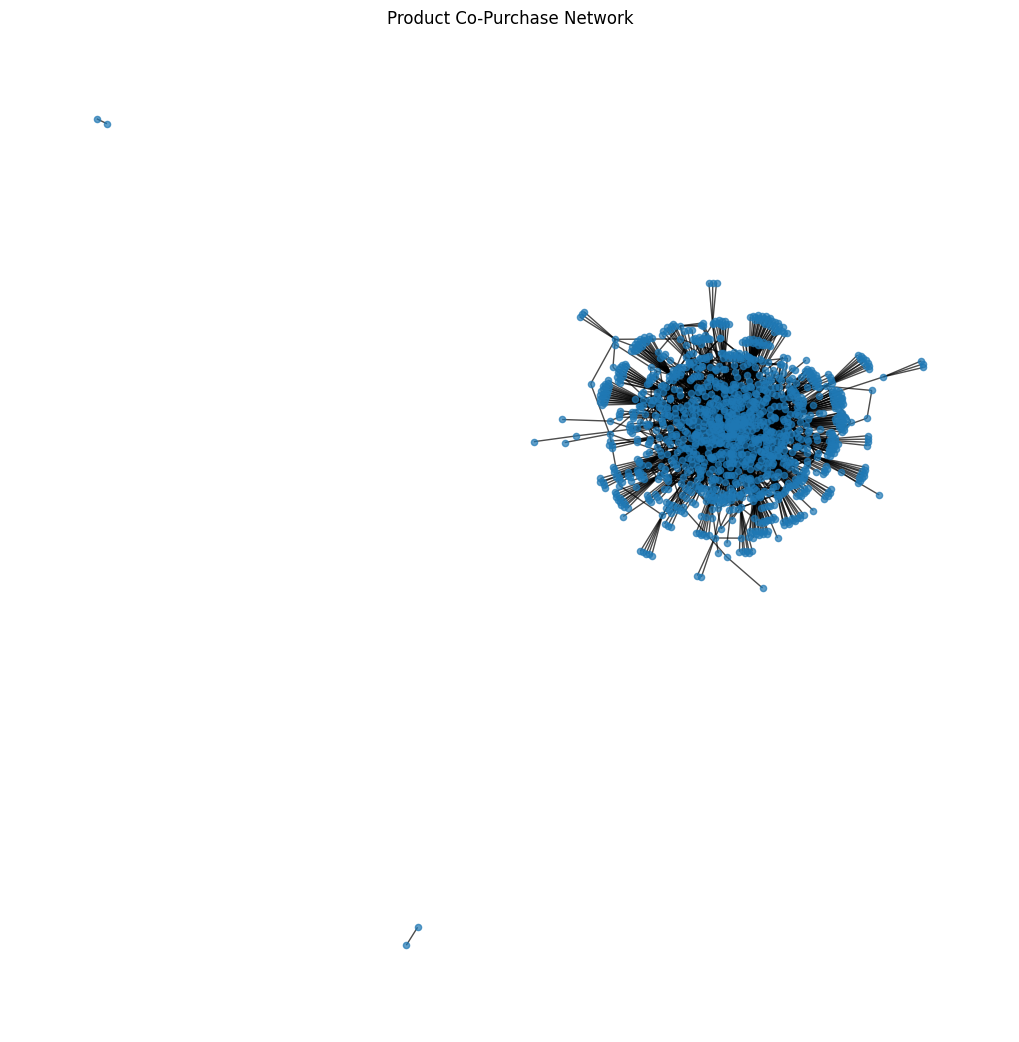

In [63]:
# Product Co-Purchase Network
product_G = nx.Graph()
product_pairs = df_sample.groupby(['StockCode', 'CustomerID']).size().reset_index()
for _, row in product_pairs.iterrows():
    product_G.add_edge(row['StockCode'], row['CustomerID'])
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(product_G)
nx.draw(product_G, pos, node_size=20, alpha=0.7)
plt.title("Product Co-Purchase Network")
plt.show()

<ipython-input-64-390dcaba0acf>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




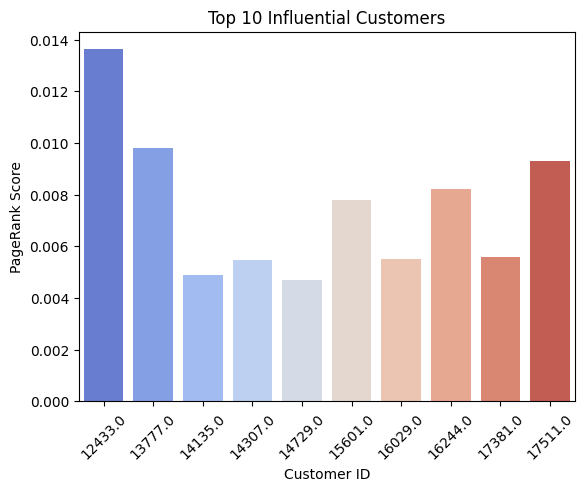

In [64]:
# Compute PageRank for Influential Customers
pagerank = nx.pagerank(G)
pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# Visualization 4: Top Influential Customers
sns.barplot(x=pagerank_df.index[:10], y=pagerank_df['PageRank'][:10], palette="coolwarm")
plt.title("Top 10 Influential Customers")
plt.xlabel("Customer ID")
plt.ylabel("PageRank Score")
plt.xticks(rotation=45)
plt.show()

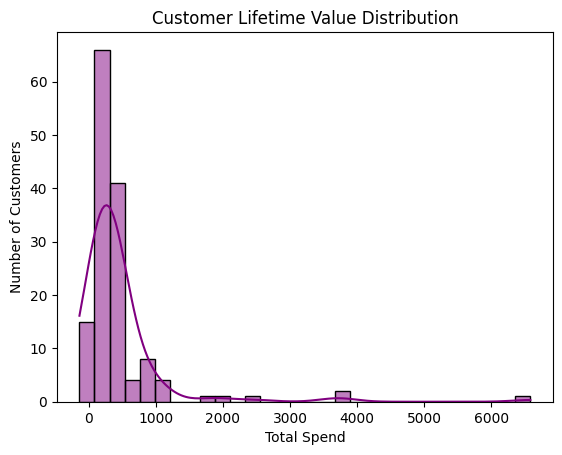

In [65]:
# Compute Customer Lifetime Value (CLV)
df_sample['Total_Spend'] = df_sample['Quantity'] * df_sample['UnitPrice']
clv = df_sample.groupby('CustomerID')['Total_Spend'].sum()
clv_df = pd.DataFrame(clv).reset_index()

# Visualization 5: Customer Lifetime Value Distribution
sns.histplot(clv_df['Total_Spend'], bins=30, kde=True, color='purple')
plt.title("Customer Lifetime Value Distribution")
plt.xlabel("Total Spend")
plt.ylabel("Number of Customers")
plt.show()

In [66]:
# Product Popularity Over Time
df_sample['InvoiceDate'] = pd.to_datetime(df_sample['InvoiceDate'])
df_sample['Month'] = df_sample['InvoiceDate'].dt.to_period("M")
product_trends = df_sample.groupby(['Month', 'StockCode'])['Quantity'].sum().reset_index()

# Visualization 6: Product Popularity Over Time
fig = px.line(product_trends, x='Month', y='Quantity', color='StockCode', title="Product Popularity Over Time")
fig.show()

TypeError: Type is not JSON serializable: Period

In [67]:
# Product Popularity Over Time
df_sample['InvoiceDate'] = pd.to_datetime(df_sample['InvoiceDate'])
df_sample['Month'] = df_sample['InvoiceDate'].dt.to_period("M")
product_trends = df_sample.groupby(['Month', 'StockCode'])['Quantity'].sum().reset_index()

# Convert 'Month' column to string before plotting
product_trends['Month'] = product_trends['Month'].astype(str)

# Visualization 6: Product Popularity Over Time
fig = px.line(product_trends, x='Month', y='Quantity', color='StockCode', title="Product Popularity Over Time")
fig.show()